## Librerias

In [1]:
import spacy
import pandas as pd
from spacy import displacy
import csv
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re



In [ ]:
#pip install pandas openpyxl spacy nltk transformers scikit-learn torch flask
#python -m spacy download en_core_web_sm

#!pip install spacy
#!conda install numpy=1.22.4 scipy
#!python -m spacy download en_core_web_sm

#!conda install openpyxl
#!pip install googletrans==4.0.0-rc1 langdetect

## Carga y Preprocesamiento de Datos

In [2]:
#leer el archivo

data_REQ = pd.read_excel("Mensajes_Clasificados.xlsx", sheet_name='Delta Share')
data_REQ.head()


,Número,Activo,Status,Aprobación,Item,Creado,Grupo de asignación,Asignado a,Breve descripción,Previsto para,...,duracion_execute,duracion_total,Fecha_Resolucion,duracion_delivered,duracion_ops,Mes_Anio_delivered,priority,reopen,parent,ticket_category
0,RITM16440211,False,Closed Complete,Approved,BrewDAT,2025-01-30 08:39:14,GL_ABI_DATA_OPS,LOURDES VILLAFAÑA,Action: Otros - Global Data Platform,JORGE NARANJO,...,2025-02-28 13:02:33,29.182986,2025-02-21 12:35:54,22.164352,16.0,Feb-2025,4 - Low,0,NaN,Delta Share
1,RITM16451126,False,Closed Complete,Approved,BrewDAT,2025-01-31 09:42:47,GL_ABI_DATA_OPS,LOURDES VILLAFAÑA,Action: Access Request - Global Data Platform,NESTOR CUELLAR,...,2025-02-10 13:31:13,14.221250,2025-02-07 14:59:06,7.219664,3.0,Feb-2025,4 - Low,0,NaN,Delta Share
2,RITM16451720,False,Closed Complete,Approved,BrewDAT,2025-01-31 10:35:33,GL_ABI_DATA_OPS,LOURDES VILLAFAÑA,Action: Access Request - Global Data Platform,NESTOR CUELLAR,...,2025-02-13 11:25:27,17.063067,2025-02-10 11:44:26,10.047836,4.0,Feb-2025,4 - Low,0,NaN,Delta Share
3,RITM16458161,False,Closed Complete,Approved,BrewDAT,2025-02-02 18:19:16,GL_ABI_DATA_OPS,LOURDES VILLAFAÑA,Action: Access Request - Global Data Platform,LIZBETH MARGARITA LEON,...,2025-02-11 19:27:47,11.779815,2025-02-07 12:23:20,4.752824,2.0,Feb-2025,4 - Low,0,NaN,Delta Share
4,RITM16476646,False,Closed Complete,Approved,BrewDAT,2025-02-04 12:58:36,GL_ABI_DATA_OPS,LOURDES VILLAFAÑA,Action: Access Request - Global Data Platform,NESTOR CUELLAR,...,2025-02-15 13:39:22,12.967060,2025-02-10 11:57:29,5.957558,2.0,Feb-2025,4 - Low,0,NaN,Delta Share


In [3]:
print(data_REQ.columns)


Index(['Número', 'Activo', 'Status', 'Aprobación', 'Item', 'Creado',
       'Grupo de asignación', 'Asignado a', 'Breve descripción',
       'Previsto para', 'Solicitid', 'Correo electrónico',
       'Fecha de aprobación', 'Descripción', 'Tipo de Solicitud N2',
       'Tipo de usuario', 'Número de empleado', 'ID', 'Closed', 'dia', 'mes',
       'anio', 'Mes_Anio', 'zona_l', 'Asignado_a_l2', 'Servicio', 'sc_catalog',
       'Descripcion', 'Mes_Anio_close', 'duracion_approve', 'duracion_execute',
       'duracion_total', 'Fecha_Resolucion', 'duracion_delivered',
       'duracion_ops', 'Mes_Anio_delivered', 'priority', 'reopen', 'parent',
       'ticket_category'],
      dtype='object')


In [4]:
data_REQ_limpio = data_REQ.copy()
print(len(data_REQ_limpio))



500


In [5]:
# ASEGURO QUE SOLO TENGA TICKETS DE 2025

data_REQ_limpio = data_REQ_limpio.drop(data_REQ_limpio[data_REQ_limpio['anio']<2025].index)
print(len(data_REQ_limpio))



500


In [6]:
# Asegurar que "Descripción" sea tipo string para evitar errores de acceso
data_REQ_limpio['Descripcion'] = data_REQ_limpio['Descripcion'].astype(str)

# Filtrar registros que sean NULL, NaN o vacíos
data_REQ_limpio = data_REQ_limpio[data_REQ_limpio['Descripcion'].notna()]  # Elimina NaN
data_REQ_limpio = data_REQ_limpio[data_REQ_limpio['Descripcion'].str.strip() != ""]  # Elimina espacios vacíos
data_REQ_limpio = data_REQ_limpio[data_REQ_limpio['Descripcion'].str.strip() != "nan"]  # Elimina espacios nan
#data_REQ_limpio = data_REQ_limpio.dropna(subset=['Descripcion'])  # Elimina cualquier otro registro con valores nulos

# Verificación del número de registros después del filtrado
print("Número de tickets después de eliminar vacíos:", len(data_REQ_limpio))



Número de tickets después de eliminar vacíos: 500


In [7]:
data_REQ_Clasificacion_traducido = data_REQ_limpio.copy()

# CAMBIO AL IDIOMA INGLÉS

from langdetect import detect
from googletrans import Translator

translator = Translator()

def detect_and_force_translate(text):
    """Detecta el idioma y traduce a inglés. Si no cambia, fuerza la traducción."""
    try:
        if not isinstance(text, str) or text.strip() == "":
            return text  # No aplica cambios si el texto está vacío
        
        lang = detect(text)  # Detectamos el idioma
        
        # Traduce si el idioma es españoL
        if lang == "es" or lang not in ["en", "fr", "de"]:
            translated_text = translator.translate(text, src="es", dest="en").text
            
            if translated_text.strip().lower() == text.strip().lower():
                translated_text = translator.translate(text + " ", src="es", dest="en").text  # Agregar espacio final
            
            return translated_text
        else:
            return text  # Si ya está en inglés no traduce
    
    except Exception as e:
        return text  

# Aplicar traducción mejorada
data_REQ_Clasificacion_traducido['translated_description'] = data_REQ_Clasificacion_traducido['Descripcion'].apply(detect_and_force_translate)





##  Entrenar y Optimizar el Modelo de Clasificación

Utilizaré Machine Learning para entrenar un modelo que aprenda a clasificar automáticamente todos los mensajes.

1️⃣ Preprocesar los datos: Limpiar texto, eliminar stopwords y preservar nombres técnicos (catalogo.esquema.tabla).

2️⃣ Convertir texto en datos numéricos: Usar TF-IDF para representar los mensajes en formato matemático.

3️⃣ Entrenar el modelo: Utilizamos Random Forest como clasificador inicial.

4️⃣ Evaluar el modelo: Medir precisión, recall y F1-score.

5️⃣ Usarlo para clasificar mensajes nuevos automáticamente




### Machine Learning

In [8]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib


# Cargar modelo de PLN
nltk.download("punkt")


# Descargar recursos de NLTK
nltk.download("stopwords")
stop_words = set(nltk.corpus.stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lourd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lourd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# **Paso 1: Preprocesamiento del texto**

def preprocess_text(text):
    """Limpieza y tokenización del texto asegurando que los nombres técnicos ALZ y DLZ se preserven correctamente."""
    text = str(text).lower()  
    
    # **Paso 1:** Marcar nombres técnicos para preservarlos
    pattern_catalog = r'\b(' \
                  r'brewdat_uc_mazana_[a-z0-9_]+\.[a-z0-9_]+\.[a-z0-9_]+' \
                  r'|' \
                  r'brewdat_uc_maz_[a-z0-9_]+\.[a-z0-9_]+\.[a-z0-9_]+' \
                  r'|' \
                  r'brewdat-uc[a-z0-9_]+\.[a-z0-9_]+\.[a-z0-9_]+' \
                  r'|' \
                  r'brewdat-maz-[a-z0-9_]+\.[a-z0-9_]+\.[a-z0-9_]+' \
                  r'|' \
                  r'aads_[A-Za-z0-9_-]+' \
                  r'|' \
                  r'brewdat-maz_[a-z0-9_]+' \
                  r')\b'

    text = re.sub(pattern_catalog, r'##\1##', text)
    #text = text.translate(str.maketrans("", "", string.punctuation.replace(".", "").replace("_", "")))
    text = text.replace("##", "")
    tokens = [word for word in nltk.word_tokenize(text) if word not in stop_words]
    doc = nlp(" ".join(tokens))
    return " ".join([token.lemma_ for token in doc])


  

In [10]:
# **Paso 2: Lectura del archivo**

#leer el archivo

data_clasificacion = data_REQ_Clasificacion_traducido.copy()



In [11]:
# **Paso 4: Aplicar preprocesamiento al texto**

data_clasificacion["processed_description"] = data_clasificacion["translated_description"].apply(preprocess_text)



In [12]:
# **Paso 5: Convertir texto en datos numéricos con TF-IDF**
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_clasificacion["processed_description"])
y = data_clasificacion["ticket_category"]  # Categorías asignadas manualmente


#Probar con BM-25 VERSION 2.0 DE tf-idf
# embeddings


In [13]:
# **Paso 6: Dividir datos en entrenamiento y prueba**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balanceo
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)



In [14]:
# Ajusto los hiperparametros de Random Forest

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train_smote, y_train_smote)
best_rf = grid_search.best_estimator_




In [15]:
# SVM

svm_model = SVC(C=1.0, kernel="linear", probability=True)
svm_model.fit(X_train_smote, y_train_smote)



SVC(kernel='linear', probability=True)

In [16]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train_smote, y_train_smote)



GradientBoostingClassifier()

In [17]:
# Evaluación de modelos
models = {
    "Random Forest": best_rf,
    "SVM": svm_model,
    "Gradient Boosting": gb_model
}

for name, model in models.items():
    print(f"\nEvaluación de {name}:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))





Evaluación de Random Forest:
                     precision    recall  f1-score   support

AADS Group - Acceso       0.89      1.00      0.94        16
       ALZ - Acceso       0.91      0.83      0.87        12
       DLZ - Acceso       0.91      1.00      0.95        21
        Delta Share       1.00      1.00      1.00        22
             GitHub       1.00      1.00      1.00        16
     Otra solicitud       1.00      0.77      0.87        13

           accuracy                           0.95       100
          macro avg       0.95      0.93      0.94       100
       weighted avg       0.95      0.95      0.95       100


Evaluación de SVM:
                     precision    recall  f1-score   support

AADS Group - Acceso       0.88      0.88      0.88        16
       ALZ - Acceso       0.65      0.92      0.76        12
       DLZ - Acceso       0.89      0.76      0.82        21
        Delta Share       0.95      0.86      0.90        22
             GitHub       1.00 

In [18]:
# Red Neuronal

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Codificar etiquetas
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Calcular pesos de clase
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_enc), y=y_train_enc)
weights = dict(enumerate(weights))

# Arquitectura mejorada
nn_model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")
])

nn_model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
nn_model.fit(X_train.toarray(), y_train_enc, epochs=20, batch_size=16, validation_split=0.2, class_weight=weights)




Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2456 - loss: 1.7867 - val_accuracy: 0.4500 - val_loss: 1.7772
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5494 - loss: 1.3393 - val_accuracy: 0.5250 - val_loss: 1.7538
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7749 - loss: 0.9715 - val_accuracy: 0.6000 - val_loss: 1.7123
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8677 - loss: 0.6631 - val_accuracy: 0.7125 - val_loss: 1.6549
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8830 - loss: 0.4761 - val_accuracy: 0.7625 - val_loss: 1.5926
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9482 - loss: 0.3016 - val_accuracy: 0.7750 - val_loss: 1.5305
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9678 - loss: 0.2180 - val_accuracy: 0.7875 - val_loss: 1.4628
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9670 - loss: 0.1507 - val_accuracy: 0.8000 - val_loss

### BERT simple

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

df = data_clasificacion[["translated_description", "ticket_category"]].dropna().reset_index(drop=True)

# Codificar etiquetas
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["ticket_category"])

# Dividir datos
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["translated_description"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
)


# Tokenizar
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt")




In [20]:
# Crear dataset en PyTorch

import torch

class TicketDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TicketDataset(train_encodings, train_labels)
test_dataset = TicketDataset(test_encodings, test_labels)


#Calcular pesos por clase
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)




In [21]:
#!pip install --upgrade transformers
#!pip install transformers datasets scikit-learn torch


In [22]:
# Entrenar modelo BERT para clasificación

from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_encoder.classes_)
)

model.classifier.weight.data.normal_(mean=0.0, std=0.02)


"""
training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    save_strategy="no",
    logging_steps=10
)
"""

from torch.optim import AdamW
#from transformers import AdamW
from torch.utils.data import DataLoader
from transformers import get_scheduler

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 6
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Entrenamiento manual
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6


In [23]:
# Evaluación del modelo

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))



                     precision    recall  f1-score   support

AADS Group - Acceso       1.00      0.81      0.90        16
       ALZ - Acceso       0.65      0.92      0.76        12
       DLZ - Acceso       0.85      0.81      0.83        21
        Delta Share       0.89      0.73      0.80        22
             GitHub       1.00      1.00      1.00        16
     Otra solicitud       0.75      0.92      0.83        13

           accuracy                           0.85       100
          macro avg       0.86      0.86      0.85       100
       weighted avg       0.87      0.85      0.85       100



In [24]:
# **Ejemplo de uso**
def predict_bert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    return label_encoder.inverse_transform([pred])[0]

# Ejemplo:
predict_bert("Please grant access to brewdat_uc_mazana_prod")




'DLZ - Acceso'

## BERT con tokens especiales

In [25]:
#!pip install transformers torch scikit-learn


In [26]:
# Insertar tokens especiales

import re

def insertar_tokens_entidad(texto):
    texto = texto.lower()

    # Tokens técnicos basados en expresiones regulares
    texto = re.sub(r'(brewdat_uc_mazana_[a-z]+\.[a-z0-9_]+\.[a-z0-9_]+)', r'[ALZ]\1[/ALZ]', texto)
    texto = re.sub(r'(brewdat_uc_maz_[a-z]+\.[a-z0-9_]+\.[a-z0-9_]+)', r'[DLZ]\1[/DLZ]', texto)
    texto = re.sub(r'(brewdat_uc_maz_bees_1p_ds\.[a-z0-9_]+)', r'[BEES]\1[/BEES]', texto)
    texto = re.sub(r'([a-z0-9_-]+-adbwks-[a-z]+)', r'[ADBWKS]\1[/ADBWKS]', texto)
    texto = re.sub(r'(aads_[a-z0-9_-]+)', r'[AADS]\1[/AADS]', texto)

    # Palabras clave agrupadas por intención semántica
    delta_keywords = ["delta-sharing", "delta sharing", "deltasharing", "delta share", "deltashare", "stop sharing", "make available", "available"]
    for word in delta_keywords:
        texto = re.sub(rf'\b{re.escape(word)}\b', r'[DELTA]' + word + r'[/DELTA]', texto)

    aads_create = ["create", "creation", "new group"]
    for word in aads_create:
        texto = re.sub(rf'\b{re.escape(word)}\b', r'[AADS_CREATE]' + word + r'[/AADS_CREATE]', texto)

    aads_add = ["add", "added", "include", "ad group", "append", "join", "incorporate"]
    for word in aads_add:
        texto = re.sub(rf'\b{re.escape(word)}\b', r'[AADS_ADD]' + word + r'[/AADS_ADD]', texto)

    access_words = ["grant access", "give access", "access", "permission", "read", "table"]
    for word in access_words:
        texto = re.sub(rf'\b{re.escape(word)}\b', r'[ACCESS]' + word + r'[/ACCESS]', texto)

    github_keywords = ["github"]
    for word in github_keywords:
        texto = re.sub(rf'\b{re.escape(word)}\b', r'[GITHUB]' + word + r'[/GITHUB]', texto)

    return texto
    

data_clasificacion["texto_con_tokens"] = data_clasificacion["translated_description"].apply(insertar_tokens_entidad)



In [27]:
# Tokenizador expandido

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokens_especiales = [
    "[ALZ]", "[/ALZ]", "[DLZ]", "[/DLZ]", "[AADS]", "[/AADS]", "[ADBWKS]", "[/ADBWKS]",
    "[AADS_CREATE]", "[/AADS_CREATE]", "[AADS_ADD]", "[/AADS_ADD]",
    "[DELTA]", "[/DELTA]", "[ACCESS]", "[/ACCESS]",
    "[BEES]", "[/BEES]", "[GITHUB]", "[/GITHUB]"
]
tokenizer.add_tokens(tokens_especiales)



20

In [28]:
# Preparación de los datos

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import torch

label_encoder = LabelEncoder()
data_clasificacion["label"] = label_encoder.fit_transform(data_clasificacion["ticket_category"])

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_clasificacion["texto_con_tokens"].tolist(),
    data_clasificacion["label"].tolist(),
    test_size=0.2,
    random_state=42
)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt")

class TicketDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TicketDataset(train_encodings, train_labels)
test_dataset = TicketDataset(test_encodings, test_labels)



In [29]:
# Modelo BERT con atención + vocabulario extendido

from transformers import BertModel
import torch.nn as nn

class BertWithAttentionClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.bert.resize_token_embeddings(len(tokenizer))
        self.attention = nn.Linear(self.bert.config.hidden_size, 1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden = outputs.last_hidden_state
        attn_scores = self.attention(hidden)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * hidden, dim=1)
        return context, attn_weights, self.classifier(context)

        

In [30]:
# Entrenamiento

from torch.utils.data import DataLoader
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert2 = BertWithAttentionClassifier(num_labels=len(label_encoder.classes_)).to(device)

unique_classes = np.unique(train_labels)
class_weights = compute_class_weight("balanced", classes=unique_classes, y=train_labels)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

optimizer = AdamW(bert2.parameters(), lr=5e-5)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

bert2.train()
for epoch in range(6):
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        _, _, logits = bert2(batch["input_ids"], batch["attention_mask"])
        loss = loss_fn(logits, batch["labels"])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")
    

        

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Epoch 1 - Loss: 1.1883
Epoch 2 - Loss: 0.4901
Epoch 3 - Loss: 0.3323
Epoch 4 - Loss: 0.1494
Epoch 5 - Loss: 0.0882
Epoch 6 - Loss: 0.0690


In [31]:
# Evaluación

from sklearn.metrics import classification_report
test_loader = DataLoader(test_dataset, batch_size=8)
bert2.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        _, _, logits = bert2(batch["input_ids"], batch["attention_mask"])
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))



                     precision    recall  f1-score   support

AADS Group - Acceso       1.00      0.81      0.90        16
       ALZ - Acceso       0.92      0.92      0.92        12
       DLZ - Acceso       0.90      0.90      0.90        21
        Delta Share       0.92      1.00      0.96        22
             GitHub       1.00      1.00      1.00        16
     Otra solicitud       0.79      0.85      0.81        13

           accuracy                           0.92       100
          macro avg       0.92      0.91      0.91       100
       weighted avg       0.92      0.92      0.92       100



In [33]:
# Visualización

# Visualización

import matplotlib.pyplot as plt
import seaborn as sns

def visualizar_atencion(texto):
    bert2.eval()
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        _, attn_weights, logits = bert2(inputs["input_ids"], inputs["attention_mask"])
        pred = torch.argmax(logits, dim=1).item()

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    pesos = attn_weights[0].squeeze().cpu().numpy()

    plt.figure(figsize=(12, 1.5))
    sns.barplot(x=tokens, y=pesos, palette="coolwarm")
    plt.title(f"Predicción: {label_encoder.inverse_transform([pred])[0]}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

        

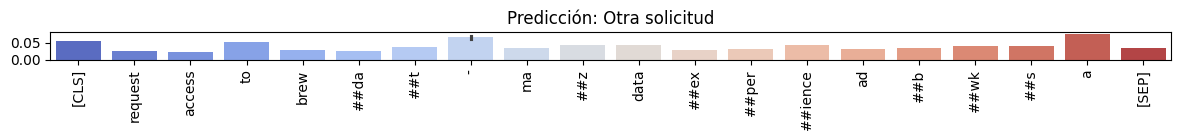

In [34]:
visualizar_atencion("Request access to brewdat-maz-dataexperience-adbwks-a")

### Comparación con Gráficas

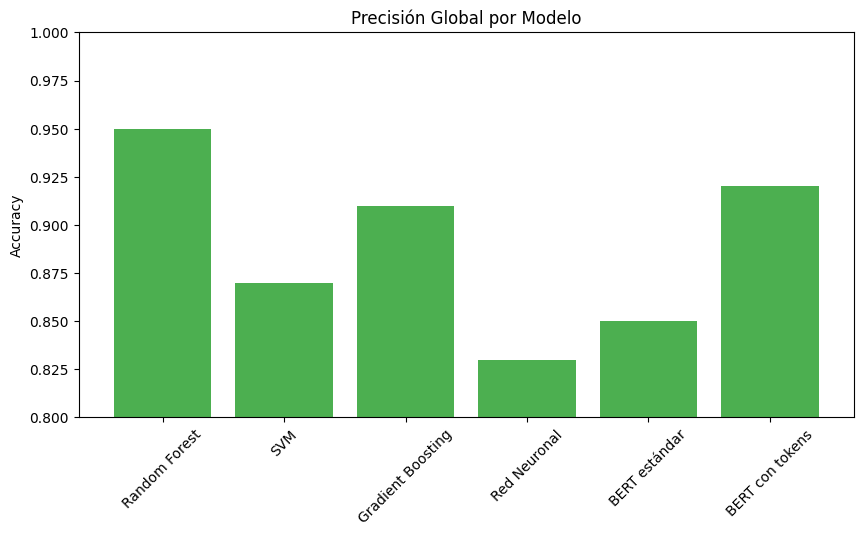

In [35]:
# Comparación de precisión general por modelo

import matplotlib.pyplot as plt

modelos = ["Random Forest", "SVM", "Gradient Boosting", "Red Neuronal", "BERT estándar", "BERT con tokens"]
accuracy = [0.95, 0.87, 0.91, 0.83, 0.85, 0.92]

plt.figure(figsize=(10,5))
plt.bar(modelos, accuracy, color="#4CAF50")
plt.ylim(0.80, 1.00)
plt.title("Precisión Global por Modelo")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()




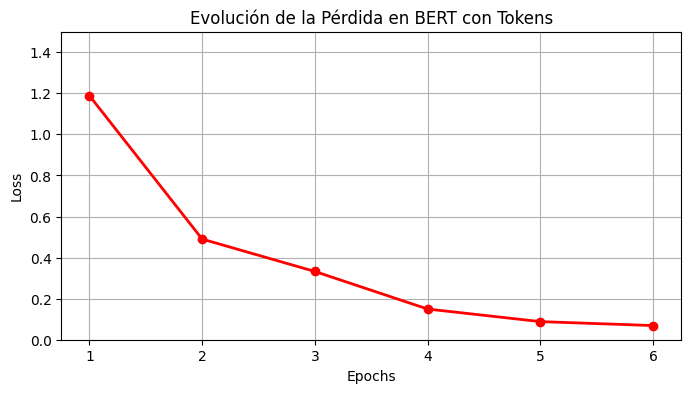

In [36]:
# Perdida de BERT con tokens

import numpy as np

epochs = np.arange(1, 7)
loss_values = [1.1883, 0.4901, 0.3323, 0.1494, 0.0882, 0.0690]

plt.figure(figsize=(8,4))
plt.plot(epochs, loss_values, marker='o', color="red", linewidth=2)
plt.title("Evolución de la Pérdida en BERT con Tokens")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.ylim(0, 1.5)
plt.grid(True)
plt.show()



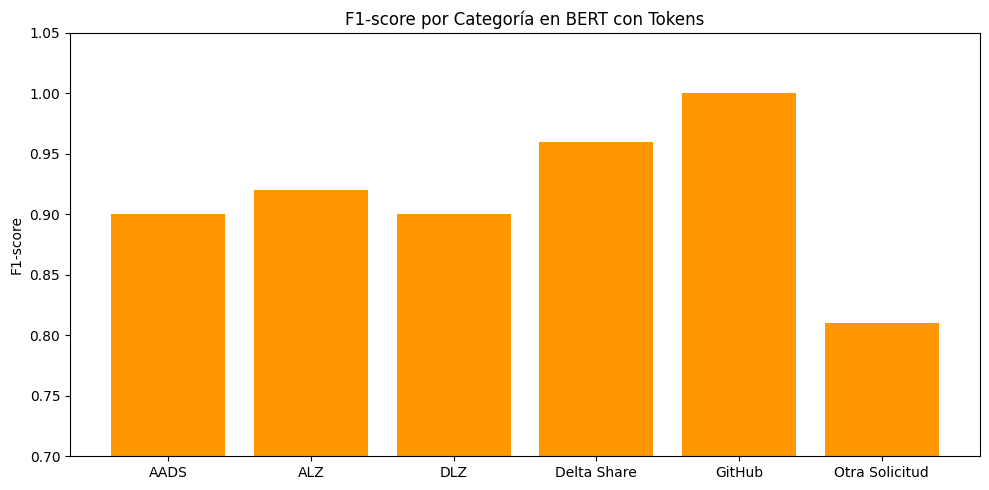

In [37]:
# F1-score por clase de BERT con tokens

import numpy as np

clases = ["AADS", "ALZ", "DLZ", "Delta Share", "GitHub", "Otra Solicitud"]
bert2_f1 = [0.90, 0.92, 0.90, 0.96, 1.00, 0.81]

x = np.arange(len(clases))
plt.figure(figsize=(10,5))
plt.bar(x, bert2_f1, color="#FF9800")
plt.xticks(x, clases)
plt.ylabel("F1-score")
plt.title("F1-score por Categoría en BERT con Tokens")
plt.ylim(0.7, 1.05)
plt.tight_layout()
plt.show()



In [ ]:
# Evolución del rendimiento en el tiempo

etapas = [
    "Random Forest", "Gradient Boosting", "BERT clásico", "BERT 2"
]
macro_f1 = [0.91, 0.89, 0.90, 0.94]

plt.figure(figsize=(8, 4))
plt.plot(etapas, macro_f1, marker='o', color="#9C27B0", linewidth=2)
plt.title("Evolución del Macro F1-Score")
plt.ylabel("Macro F1")
plt.ylim(0.85, 0.95)
for i, val in enumerate(macro_f1):
    plt.text(i, val + 0.005, f"{val:.2f}", ha='center')
plt.grid(True)
plt.tight_layout()
plt.show()



## Sistema de Asignación Automática de Tickets a Agentes

In [45]:
# Paso 1: Definir agentes, sus especialidades y su carga de trabajo actual

agentes = {
    "Agente_1_Experto": {
        "especialidades": ["BrewDat", "Databricks", "Azure Portal", "ML Platform", "GitHub", "Delta Share", "Otro"],
        "tickets_asignados": 12
    },
    "Agente_2_Senior": {
        "especialidades": ["BrewDat", "Azure Portal", "ML Platform", "Databricks", "GitHub"],
        "tickets_asignados": 7
    },
    "Agente_2_Junior_1": {
        "especialidades": ["BrewDat", "GitHub"],
        "tickets_asignados": 10
    },
    "Agente_2_Junior_2": {
        "especialidades": ["BrewDat", "GitHub"],
        "tickets_asignados": 5
    },
    "Agente_2_Junior_3": {
        "especialidades": ["BrewDat", "GitHub"],
        "tickets_asignados": 9
    }
}



In [46]:
# Paso 2: Mapeo de categorías 

categoria_a_tema = {
    "AADS Group - Acceso": "Azure Portal",
    "ALZ - Acceso": "BrewDat",
    "DLZ - Acceso": "ML Platform",
    "Delta Share": "Databricks",
    "GitHub": "GitHub",
    "Otra solicitud": "Otro"
}



In [47]:
# Paso 3: Asignación automática

def asignar_agente(categoria_predicha, agentes_dict, estrategia="min_carga"):
    tema = categoria_a_tema.get(categoria_predicha, None)
    if not tema:
        return "Categoría desconocida"

    # Buscar agentes que tengan ese tema como especialidad
    candidatos = [
        (nombre, datos["tickets_asignados"])
        for nombre, datos in agentes_dict.items()
        if tema in datos["especialidades"]
    ]

    if not candidatos:
        return "Sin agente especializado disponible"

    # Estrategia por carga mínima
    agente_asignado = sorted(candidatos, key=lambda x: x[1])[0][0]
    agentes_dict[agente_asignado]["tickets_asignados"] += 1
    return agente_asignado

    

In [48]:
# Paso 4: Función para predecir categoría con BERT y asignar agente

def clasificar_y_asignar_bert2(ticket_texto):
    texto_preprocesado = insertar_tokens_entidad(ticket_texto)
    inputs = tokenizer(texto_preprocesado, return_tensors="pt", truncation=True, padding=True).to(device)

    bert2.eval()
    with torch.no_grad():
        _, _, logits = bert2(inputs["input_ids"], inputs["attention_mask"])
        pred_label = torch.argmax(logits, dim=1).item()
        categoria = label_encoder.inverse_transform([pred_label])[0]

    agente = asignar_agente(categoria, agentes)
    return categoria, agente



    

### Pruebas en Excel

FUNCIONALIDADES INCLUIDAS
- Lee un archivo Excel de tickets en español
- Traduce cada ticket al inglés
- Inserta tokens técnicos
- Predice la categoría usando BERT 2
- Asigna un agente automáticamente
- Genera una explicación en lenguaje natural
- Exporta los resultados a un nuevo Excel


In [54]:
#!pip install deep-translator


In [57]:
from deep_translator import GoogleTranslator

# PASO 1: Cargar archivo Excel de entrada
df_tickets = pd.read_excel("tickets_pendientes.xlsx")



# PASO 2: Traducir cada ticket
def traducir_a_ingles(texto):
    try:
        return GoogleTranslator(source='auto', target='en').translate(texto)
    except Exception as e:
        return f"[Error de traducción] {e}"

df_tickets["descripcion_traducida"] = df_tickets["descripcion"].astype(str).apply(traducir_a_ingles)


# PASO 3: Función para categorizar la salida
def generar_explicacion(ticket_texto):
    texto_preprocesado = insertar_tokens_entidad(ticket_texto)
    if "[ACCESS]" in texto_preprocesado:
        return "Acceso"
    elif "[DELTA]" in texto_preprocesado:
        return "Delta Share"
    elif "[AADS_CREATE]" in texto_preprocesado:
        return "AADS - Crear"
    elif "[AADS_ADD]" in texto_preprocesado:
        return "AADS - Add"
    elif "[GITHUB]" in texto_preprocesado:
        return "GitHub"
    elif "[DLZ]" in texto_preprocesado:
        return "DLZ"
    elif "[ALZ]" in texto_preprocesado:
        return "ALZ"
    elif "[ADBWKS]" in texto_preprocesado:
        return "ADBWKS"
    else:
        return "Otra solicitud"



# PASO 4: Predecir categoría, asignar agente y generar explicación
predicciones = []
asignaciones = []
explicaciones = []

for texto in df_tickets["descripcion_traducida"]:
    try:
        categoria, agente = clasificar_y_asignar_bert2(texto)
        explicacion = generar_explicacion(texto)
    except Exception as e:
        categoria = "Error"
        agente = "Error"
        explicacion = f"Error en predicción: {str(e)}"
    
    predicciones.append(categoria)
    asignaciones.append(agente)
    explicaciones.append(explicacion)



# PASO 5: Guardar resultados
df_tickets["categoria_predicha"] = predicciones
df_tickets["agente_asignado"] = asignaciones
df_tickets["explicacion"] = explicaciones



# PASO 6: Exportar a nuevo archivo
df_tickets.to_excel("tickets_clasificados_en_ingles_BERT2.xlsx", index=False)
print("Archivo exportado: tickets_clasificados_en_ingles_BERT2.xlsx")





Archivo exportado: tickets_clasificados_en_ingles_BERT2.xlsx


### Pruebas manuales

In [56]:
print(type(bert2))


<class '__main__.BertWithAttentionClassifier'>


In [50]:
# Paso 5: Prueba de varios tickets y Exportar a Excel

tickets = [
    "Please create new group AADS_mexico_finanzas",
    "Grant access to brewdat_uc_maz_prod.clientos.tabla",
    "Enable delta sharing for business users",
    "Pipeline in github is not working",
    "Need access to brewdat-maz_finanzas",
]

for t in tickets:
    categoria, agente = clasificar_y_asignar_bert2(t)
    print(f"Ticket: {t}")
    print(f"Categoría predicha: {categoria}")
    print(f"Asignado a: {agente}")
    print("-" * 50)
    




Ticket: Please create new group AADS_mexico_finanzas
Categoría predicha: AADS Group - Acceso
Asignado a: Agente_2_Senior
--------------------------------------------------
Ticket: Grant access to brewdat_uc_maz_prod.clientos.tabla
Categoría predicha: DLZ - Acceso
Asignado a: Agente_2_Senior
--------------------------------------------------
Ticket: Enable delta sharing for business users
Categoría predicha: Delta Share
Asignado a: Agente_2_Senior
--------------------------------------------------
Ticket: Pipeline in github is not working
Categoría predicha: GitHub
Asignado a: Agente_2_Junior_2
--------------------------------------------------
Ticket: Need access to brewdat-maz_finanzas
Categoría predicha: Otra solicitud
Asignado a: Agente_1_Experto
--------------------------------------------------


In [ ]:
data_clasificacion.to_excel("data_clasificacion.xlsx")

## Guardar el modelo para no tener que entrenarlo nuevamente

In [58]:
# Guardar el modelo y el tokenizer

# Crear carpeta para guardar el modelo si no existe
import os
output_dir = "modelo_bert2_guardado"
os.makedirs(output_dir, exist_ok=True)

# Guardar pesos del modelo
torch.save(bert2.state_dict(), os.path.join(output_dir, "bert2_weights.pt"))

# Guardar tokenizer
tokenizer.save_pretrained(output_dir)



('modelo_bert2_guardado\\tokenizer_config.json',
 'modelo_bert2_guardado\\special_tokens_map.json',
 'modelo_bert2_guardado\\vocab.txt',
 'modelo_bert2_guardado\\added_tokens.json')

In [ ]:
# Cargar el modelo nuevamente

# Cargar tokenizer personalizado
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("modelo_bert2_guardado")

# Reconstruir arquitectura del modelo
modelo_cargado = BertWithAttentionClassifier(num_labels=len(label_encoder.classes_))
modelo_cargado.load_state_dict(torch.load("modelo_bert2_guardado/bert2_weights.pt"))
modelo_cargado.to(device)
modelo_cargado.eval()



Guardar y luego recargar de forma segura todo tu modelo BERT 2, incluyendo:
- Pesos del modelo BERT 2
- Tokenizer personalizado con tokens especiales
- LabelEncoder con las clases
- Función load_model() para recargar todo fácilmente



In [59]:
# GUARDAR MODELO COMPLETO

import os
import joblib
import torch
from transformers import BertTokenizer

def save_model_system(modelo, tokenizer, label_encoder, ruta="modelo_bert2_guardado"):
    os.makedirs(ruta, exist_ok=True)
    
    # Guardar pesos del modelo
    torch.save(modelo.state_dict(), os.path.join(ruta, "bert2_weights.pt"))

    # Guardar tokenizer extendido
    tokenizer.save_pretrained(ruta)

    # Guardar label_encoder con joblib
    joblib.dump(label_encoder, os.path.join(ruta, "label_encoder.pkl"))

    print(f"Modelo, tokenizer y label_encoder guardados en: {ruta}")



# FUNCION UTILITARIA PARA CARGAR TODO

def load_model_system(ruta="modelo_bert2_guardado", device="cuda" if torch.cuda.is_available() else "cpu"):
    from transformers import BertTokenizer
    import joblib

    # Cargar tokenizer extendido
    tokenizer = BertTokenizer.from_pretrained(ruta)

    # Cargar label encoder
    label_encoder = joblib.load(os.path.join(ruta, "label_encoder.pkl"))

    # Reconstruir arquitectura del modelo
    modelo_cargado = BertWithAttentionClassifier(num_labels=len(label_encoder.classes_))
    modelo_cargado.load_state_dict(torch.load(os.path.join(ruta, "bert2_weights.pt"), map_location=device))
    modelo_cargado.to(device)
    modelo_cargado.eval()

    print("Sistema cargado: modelo + tokenizer + label_encoder")
    return modelo_cargado, tokenizer, label_encoder

    

In [60]:
# Guardar después de entrenar
save_model_system(bert2, tokenizer, label_encoder)



Modelo, tokenizer y label_encoder guardados en: modelo_bert2_guardado


In [ ]:
# Cargar modelo completo y mostrar estado del sistema
#  Imprime un resumen del estado del sistema al cargar el modelo para verificarque todo está listo para predecir.

bert2, tokenizer, label_encoder = load_model_system()

print("MODELO CARGADO CORRECTAMENTE")
print("-" * 50)
print(f"Tokenizer cargado con vocabulario de tamaño: {len(tokenizer)}")
print(f"LabelEncoder con {len(label_encoder.classes_)} clases:")
print("    →", list(label_encoder.classes_))
print("-" * 50)
print("El modelo está en modo evaluación:", not bert2.training)



## Productivizar el modelo

- Flask
- APIRest


In [ ]:
# app.py
from fastapi import FastAPI
from pydantic import BaseModel
import torch
import joblib

# Cargar modelo y componentes
from modelo_bert import BertWithAttentionClassifier, insertar_tokens_entidad, generar_explicacion, asignar_agente
from transformers import BertTokenizer

app = FastAPI()

# Carga de componentes
model_path = "modelo_bert2_guardado"
tokenizer = BertTokenizer.from_pretrained(model_path)
label_encoder = joblib.load(f"{model_path}/label_encoder.pkl")

model = BertWithAttentionClassifier(num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(f"{model_path}/bert2_weights.pt", map_location="cpu"))
model.eval()

# Entrada de la API
class Ticket(BaseModel):
    descripcion: str

@app.post("/clasificar/")
def clasificar(ticket: Ticket):
    texto = insertar_tokens_entidad(ticket.descripcion)
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        _, _, logits = model(inputs["input_ids"], inputs["attention_mask"])
        pred = torch.argmax(logits, dim=1).item()

    categoria = label_encoder.inverse_transform([pred])[0]
    agente = asignar_agente(categoria, agentes)
    explicacion = generar_explicacion(ticket.descripcion)

    return {
        "categoria_predicha": categoria,
        "agente_asignado": agente,
        "explicacion": explicacion
    }

In [ ]:
# Ejecutar el servicio: 

uvicorn app:app --reload



In [ ]:
# Conectarse

import requests

r = requests.post("http://localhost:8000/clasificar/", json={"descripcion": "Necesito acceso a la tabla brewdat_uc_mazana_sales"})
print(r.json())



In [ ]:
# Estructura recomendada del archivo Python

# modelo_bert.py

import torch
import torch.nn as nn
import re

# Arquitectura del modelo con atención
class BertWithAttentionClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        from transformers import BertModel
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.attention = nn.Linear(self.bert.config.hidden_size, 1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden = outputs.last_hidden_state
        attn_scores = self.attention(hidden)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * hidden, dim=1)
        return context, attn_weights, self.classifier(context)

# Preprocesamiento técnico con tokens especiales
def insertar_tokens_entidad(texto):
    texto = texto.lower()
    texto = re.sub(r'(brewdat_uc_maz_[a-z]+\.[a-z0-9_]+\.[a-z0-9_]+)', r'[DLZ]\1[/DLZ]', texto)
    texto = re.sub(r'(brewdat_uc_mazana_[a-z]+\.[a-z0-9_]+\.[a-z0-9_]+)', r'[ALZ]\1[/ALZ]', texto)
    texto = re.sub(r'(brewdat-maz-[a-z]+-adbwks-[a-z]+)', r'[ADBWKS]\1[/ADBWKS]', texto)
    texto = re.sub(r'(aads_[a-z0-9_-]+)', r'[AADS]\1[/AADS]', texto)

    # Tokens por patrones semánticos
    for w in ["delta-sharing", "delta sharing", "deltasharing"]:
        texto = re.sub(rf'\b{w}\b', r'[DELTA]'+w+r'[/DELTA]', texto)
    for w in ["access", "permission", "table", "grant access", "read"]:
        texto = re.sub(rf'\b{w}\b', r'[ACCESS]'+w+r'[/ACCESS]', texto)
    return texto

# Generador de explicaciones
def generar_explicacion(texto_original):
    t = insertar_tokens_entidad(texto_original)
    if "[ACCESS]" in t:
        return "Solicitud de Acceso: El usuario solicita permisos sobre recursos técnicos."
    elif "[DELTA]" in t:
        return "Compartición Delta Share: Acceso solicitado a objetos compartidos."
    elif "[AADS_CREATE]" in t:
        return "Creación de Grupo Azure: Solicitud de nuevo grupo de seguridad en Azure AD."
    elif "[GITHUB]" in t:
        return "Problema con GitHub: Error reportado en flujo CI/CD o repositorio."
    elif "[DLZ]" in t or "[ALZ]" in t:
        return "Acceso a base de datos corporativa: Solicitud sobre DLZ o ALZ."
    elif "[ADBWKS]" in t:
        return "Acceso a workspace de Databricks: Workspace técnico identificado (ADBWKS)."
    return "Otra solicitud general: No se detectaron tokens clave."

# Asignación automática a agentes
agentes = {
    "Agente_1_Experto": {
        "especialidades": ["BrewDat", "Databricks", "Azure Portal", "ML Platform", "GitHub", "Delta Share", "Otro"],
        "tickets_asignados": 12
    },
    "Agente_2_Senior": {
        "especialidades": ["BrewDat", "Azure Portal", "ML Platform", "Databricks", "GitHub"],
        "tickets_asignados": 7
    },
    "Agente_2_Junior_1": {
        "especialidades": ["BrewDat", "GitHub"],
        "tickets_asignados": 10
    }
}

categoria_a_tema = {
    "AADS Group - Acceso": "Azure Portal",
    "ALZ - Acceso": "BrewDat",
    "DLZ - Acceso": "ML Platform",
    "Delta Share": "Databricks",
    "GitHub": "GitHub",
    "Otra solicitud": "Otro"
}

def asignar_agente(categoria_predicha, agentes_dict=agentes):
    tema = categoria_a_tema.get(categoria_predicha, None)
    if not tema:
        return "Categoría desconocida"
    candidatos = [(k, v["tickets_asignados"]) for k, v in agentes_dict.items() if tema in v["especialidades"]]
    if not candidatos:
        return "Sin agente especializado disponible"
    elegido = sorted(candidatos, key=lambda x: x[1])[0][0]
    agentes_dict[elegido]["tickets_asignados"] += 1
    return elegido


In [ ]:
# Uso del modelo

from modelo_bert import BertWithAttentionClassifier, insertar_tokens_entidad, generar_explicacion, asignar_agente

